In [1]:
#import streamlit as st
#import pandas as pd
#import altair as alt
#import plotly.express as px

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import os
import platform
import glob

In [3]:
if platform.system()=='Windows': 
    #Directorios Windows
    os.chdir(
        r"G:\.shortcut-targets-by-id\120bUa35y3FJzvumWahpOx1qS9I6TIrhb\GIGANAV")

if platform.system()=='Darwin':
    os.chdir(
        '/Users/juliandiazparra/Library/CloudStorage/GoogleDrive-julian.adiaz@hotmail.com/Mi unidad/Negocios/Familiar/GIGANAV')

folder=os.getcwd()
data=os.path.join(folder,'Datos')
provisiones=os.path.join(data,'Provisiones')
facturas=os.path.join(data,'Facturas')
tickets=os.path.join(data,'Tickets')
usuarios=os.path.join(data,'Usuarios')
egresos=os.path.join(data,'Egresos')
transacciones=os.path.join(data,'Transacciones')
analisis=os.path.join(folder,'Operacion/Analisis')
resultados=os.path.join(analisis,'Resultados')
bases=os.path.join(analisis,'Bases_analisis')
outputs=os.path.join(analisis,'Outputs')
plots=os.path.join(outputs,'Gráficos')
usuarios_clean=os.path.join(bases,'Usuarios')
transac_clean=os.path.join(bases,'Transacciones')
tickets_clean=os.path.join(bases,'Tickets')
facturas_clean=os.path.join(bases,'Facturas')
egresos_clean=os.path.join(bases,'Egresos')
working=os.path.join(bases,'Bases_trabajo')
codigo=os.path.join(folder,'Operacion/Analisis/Código')
conciliaciones=os.path.join(folder,'Operacion/Operativo/Administrativo/Conciliaciones')

## Importación base de trabajo

In [4]:
list_of_files = glob.glob(os.path.join(outputs,'Base_tickets*.csv'))
latest_file = max(list_of_files, key=os.path.getctime)
working_data=pd.read_csv(latest_file, low_memory=False)
working_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080 entries, 0 to 16079
Data columns (total 70 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             16080 non-null  int64  
 1   id_ticket              16080 non-null  int64  
 2   departamento           16080 non-null  object 
 3   nombre                 16080 non-null  object 
 4   asunto                 16080 non-null  object 
 5   tecnico                16080 non-null  object 
 6   zona                   16040 non-null  object 
 7   abierto_por            16080 non-null  object 
 8   instal                 16080 non-null  int64  
 9   soporte                16080 non-null  int64  
 10  traslado               16080 non-null  int64  
 11  retiro                 16080 non-null  int64  
 12  mantenimiento          16080 non-null  int64  
 13  facturacion            16080 non-null  int64  
 14  cambio_plan            16080 non-null  int64  
 15  su

In [5]:
working_data.loc[working_data['tecnico_1'].notna(),'tecnico_1']

0        Leonardo Quezada
2         Esneider García
4         Esneider García
6          Alfonso Arango
9          Alfonso Arango
               ...       
5807     Leonardo Quezada
5898      Esneider García
5933     Leonardo Quezada
6028      Esneider García
12256         Sair Bolaño
Name: tecnico_1, Length: 1915, dtype: object

In [6]:
#Identifico ticket si cada tecnico aparece
working_data[['tecnico_1','tecnico_2']].fillna('', inplace=True)

#Creo variable de participacion de cada tecnico
for t in list(working_data.loc[
    working_data['tecnico_1'].notna(),
    'tecnico_1'].unique()):
    
    working_data.loc[
        :,t.split()[0]
    ]=np.select([(working_data['tecnico_1']==t) |
        (working_data['tecnico_2']==t)],[1],default=0)

/var/folders/_1/wccngqsd417dbsr4pcv82tj80000gn/T/ipykernel_4936/1201060034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data[['tecnico_1','tecnico_2']].fillna('', inplace=True)


In [7]:
#Numero de tickets atendidos por tecnico/mes
num_tix_tecnicos=working_data.groupby(
    'mes_crd').agg(
    num_enc_Esneider=('Esneider','sum'), 
    num_enc_Alfonso=('Alfonso','sum'), 
    num_enc_Sair=('Sair','sum'), 
    num_enc_Leonardo=('Leonardo','sum'),
    num_enc_Jaime=('Jaime','sum')).reset_index().tail(8)#.iloc[:-1]
num_tix_tecnicos

,mes_crd,num_enc_Esneider,num_enc_Alfonso,num_enc_Sair,num_enc_Leonardo,num_enc_Jaime
26,2024-03,41,2,9,28,0
27,2024-04,85,23,33,22,0
28,2024-05,31,33,42,32,1
29,2024-06,123,82,25,45,13
30,2024-07,30,63,39,39,17
31,2024-08,141,32,14,24,0
32,2024-09,101,54,147,100,0
33,2024-10,68,26,30,29,0


In [8]:
#Promedio tiempo de respuesta por tecnico/mes
temp_res_tecnicos_summary=working_data.loc[
    working_data['Esneider']==1
].groupby('mes_crd').agg(
    temp_res_esneider=('tiempo_resol',pd.Series.mean)).merge(
    working_data.loc[
    working_data['Alfonso']==1
].groupby('mes_crd').agg(
    temp_res_alfonso=('tiempo_resol',pd.Series.mean)), 
    left_index=True, right_index=True).merge(
    working_data.loc[
    working_data['Sair']==1
].groupby('mes_crd').agg(
    temp_res_sair=('tiempo_resol',pd.Series.mean)), 
    left_index=True, right_index=True).merge(
    working_data.loc[
    working_data['Leonardo']==1
].groupby('mes_crd').agg(
    temp_res_leonardo=('tiempo_resol',pd.Series.mean)), 
    left_index=True, right_index=True).reset_index()
temp_res_tecnicos_summary

,mes_crd,temp_res_esneider,temp_res_alfonso,temp_res_sair,temp_res_leonardo
0,2024-01,1.157315,0.580307,3.100138,1.249617
1,2024-02,6.282914,2.303078,6.160362,6.070464
2,2024-03,3.373734,3.540041,3.560574,5.752671
3,2024-04,5.483799,4.118474,5.476820,4.136950
4,2024-05,8.041534,4.116548,6.026101,6.046150
5,2024-06,5.110987,3.814452,4.688127,3.654994
6,2024-07,7.221304,4.861996,4.704807,4.813156
7,2024-08,3.020278,2.677497,1.658203,3.092824
8,2024-09,2.560887,2.708966,3.270077,4.480184
9,2024-10,3.592427,2.938447,2.324983,3.135928


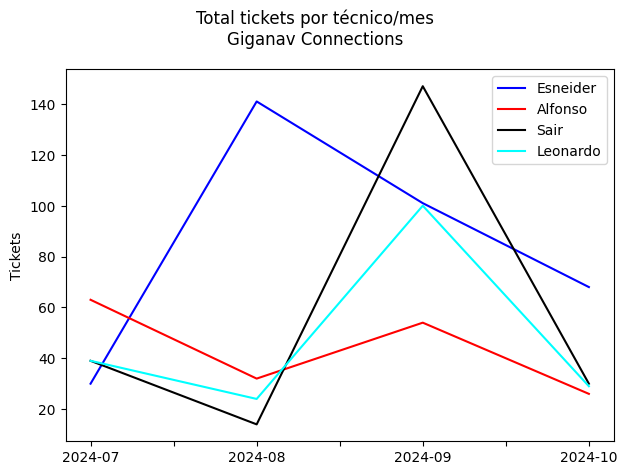

In [9]:
#Grafico tickets y tiempo respuesta promedio
fig,ax=plt.subplots()

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Esneider',
    kind='line',ax=ax,color='blue')

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Alfonso',
    kind='line',ax=ax,color='red')

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Sair',
    kind='line',ax=ax,color='black')

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Leonardo',
    kind='line',ax=ax,color='cyan')

ax.legend(['Esneider', 'Alfonso', 'Sair','Leonardo'])

plt.setp(ax, ylabel='Tickets', xlabel='')
plt.suptitle('Total tickets por técnico/mes\nGiganav Connections')
plt.tight_layout()
plt.show()

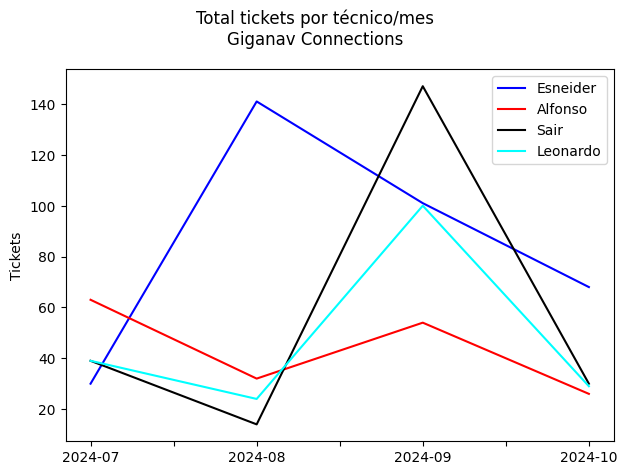

In [10]:
#Grafico tickets y tiempo respuesta promedio
fig,ax=plt.subplots()

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Esneider',
    kind='line',ax=ax,color='blue')

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Alfonso',
    kind='line',ax=ax,color='red')

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Sair',
    kind='line',ax=ax,color='black')

num_tix_tecnicos.iloc[-4:].plot(
    x='mes_crd', y='num_enc_Leonardo',
    kind='line',ax=ax,color='cyan')

ax.legend(['Esneider', 'Alfonso', 'Sair','Leonardo'])

plt.setp(ax, ylabel='Tickets', xlabel='')
plt.suptitle('Total tickets por técnico/mes\nGiganav Connections')
plt.tight_layout()
plt.show()

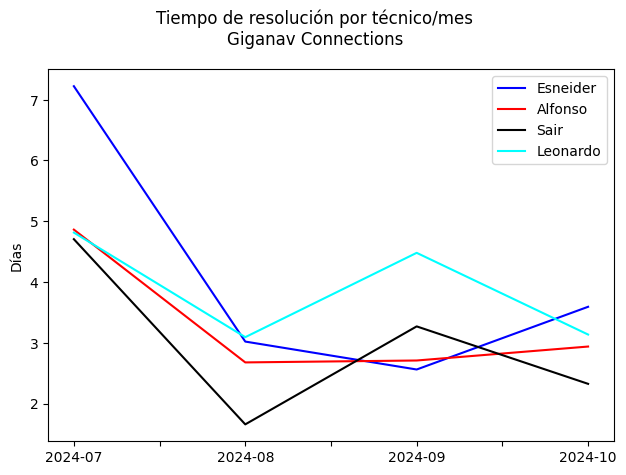

In [11]:
fig, ax=plt.subplots()

temp_res_tecnicos_summary.iloc[-4:].plot(
    x='mes_crd', y='temp_res_esneider',
    kind='line',ax=ax,color='blue', grid=True)

temp_res_tecnicos_summary.iloc[-4:].plot(
    x='mes_crd', y='temp_res_alfonso',
    kind='line',ax=ax,color='red', grid=True)

temp_res_tecnicos_summary.iloc[-4:].plot(
    x='mes_crd', y='temp_res_sair',
    kind='line',ax=ax,color='black')

temp_res_tecnicos_summary.iloc[-4:].plot(
    x='mes_crd', y='temp_res_leonardo',
    kind='line',ax=ax,color='cyan')

ax.legend(['Esneider', 'Alfonso', 'Sair','Leonardo'])

plt.setp(ax, ylabel='Días', xlabel='')
plt.suptitle('Tiempo de resolución por técnico/mes\nGiganav Connections')
plt.tight_layout()
plt.show()

Comparo con asignación de técnicos en Mikrowisp vs encuesta de material

In [12]:
#Miro cuantos tickets de los asignados en Mikrowisp
mkwp_summary_month=working_data.groupby(['mes_crd','tecnico']).agg(
    tickets_asignados=('id_ticket','nunique'), 
    temp_res=('tiempo_resol','mean'),
    num_enc_satisfaccion=('fecha_enc_sat','count'),
    promedio_satisfaccion=('calificacion_personal','mean'),
    Promotores=('promoter','sum')).reset_index().fillna(0)

empleados_names=[
    'ESNEIDER GARCIA BARAJAS','ALFONSO ARANGO TORO','SAIR BOLAÑO DURAN',
    'LEONARDO QUEZADA RAMIREZ','JAIME LEONARDO BARRERA BARAJAS',
    'MAYRA FERNANDA TRUJILLO SUAREZ','KAROLINA GUERRERO PRINCE',
    'EDGARD FONSECA','MIGUELPACHECO','No asignado']

mkwp_summary_month=mkwp_summary_month.loc[mkwp_summary_month['tecnico'].isin(empleados_names)]
mkwp_summary_month.loc[
    mkwp_summary_month['mes_crd']=='2024-08'].sort_values(
        'tickets_asignados',ascending=False)

,mes_crd,tecnico,tickets_asignados,temp_res,num_enc_satisfaccion,promedio_satisfaccion,Promotores
159,2024-08,ESNEIDER GARCIA BARAJAS,171,2.820270,3,5.000000,3.0
161,2024-08,KAROLINA GUERRERO PRINCE,135,0.230961,1,5.000000,1.0
162,2024-08,LEONARDO QUEZADA RAMIREZ,78,2.740390,5,5.000000,5.0
166,2024-08,SAIR BOLAÑO DURAN,78,3.768872,2,5.000000,2.0
157,2024-08,ALFONSO ARANGO TORO,73,3.357081,30,4.866667,30.0
165,2024-08,No asignado,67,4.288558,5,5.000000,5.0
160,2024-08,JAIME LEONARDO BARRERA BARAJAS,58,1.746330,1,5.000000,1.0
164,2024-08,MIGUELPACHECO,14,0.005528,0,0.000000,0.0
158,2024-08,EDGARD FONSECA,11,15.045976,0,0.000000,0.0
163,2024-08,MAYRA FERNANDA TRUJILLO SUAREZ,5,2.185891,0,0.000000,0.0


In [13]:
enc_tecnicos_mes_long=pd.melt(num_tix_tecnicos,id_vars='mes_crd')

enc_tecnicos_mes_long.loc[
    :,'variable']=enc_tecnicos_mes_long['variable'].str.lstrip('num_enc_')

enc_tecnicos_mes_long.rename(
    columns={'variable':'tecnico', 'value':'Encuestas respondidas'}, inplace=True)

enc_tecnicos_mes_long.loc[
    :,'tecnico'
]=np.select([enc_tecnicos_mes_long['tecnico'].str.contains('esneider',case=False),
             enc_tecnicos_mes_long['tecnico'].str.contains('alfonso',case=False),
             enc_tecnicos_mes_long['tecnico'].str.contains('sair',case=False),
             enc_tecnicos_mes_long['tecnico'].str.contains('leonardo',case=False),
             enc_tecnicos_mes_long['tecnico'].str.contains('jaime',case=False)],
            ['ESNEIDER GARCIA BARAJAS','ALFONSO ARANGO TORO','SAIR BOLAÑO DURAN',
             'LEONARDO QUEZADA RAMIREZ','JAIME LEONARDO BARRERA BARAJAS'],
            default='')

enc_tecnicos_mes_long.loc[
    enc_tecnicos_mes_long['mes_crd']=='2024-08']

,mes_crd,tecnico,Encuestas respondidas
5,2024-08,ESNEIDER GARCIA BARAJAS,141
13,2024-08,ALFONSO ARANGO TORO,32
21,2024-08,SAIR BOLAÑO DURAN,14
29,2024-08,LEONARDO QUEZADA RAMIREZ,24
37,2024-08,JAIME LEONARDO BARRERA BARAJAS,0


In [14]:
#Ahora pego datos mikrowisp con encuestas de material
summary_tecnico_mes=mkwp_summary_month.merge(
    enc_tecnicos_mes_long,
    on=['mes_crd','tecnico'],how='right').fillna(0)

summary_tecnico_mes.loc[
    :,'% encuesta material'
]=summary_tecnico_mes[
    'Encuestas respondidas']/summary_tecnico_mes[
    'tickets_asignados']

summary_tecnico_mes.loc[
    :,'% encuesta satisfaccion'
]=summary_tecnico_mes[
    'num_enc_satisfaccion']/summary_tecnico_mes[
    'tickets_asignados']

summary_tecnico_mes.loc[
    :,'Satisfaccion del usuario'
]=summary_tecnico_mes[
    'Promotores']/summary_tecnico_mes[
    'num_enc_satisfaccion']

summary_tecnico_mes.loc[
    summary_tecnico_mes['mes_crd']=='2024-08'
]

,mes_crd,tecnico,tickets_asignados,temp_res,num_enc_satisfaccion,promedio_satisfaccion,Promotores,Encuestas respondidas,% encuesta material,% encuesta satisfaccion,Satisfaccion del usuario
5,2024-08,ESNEIDER GARCIA BARAJAS,171,2.820270,3,5.000000,3.0,141,0.824561,0.017544,1.0
13,2024-08,ALFONSO ARANGO TORO,73,3.357081,30,4.866667,30.0,32,0.438356,0.410959,1.0
21,2024-08,SAIR BOLAÑO DURAN,78,3.768872,2,5.000000,2.0,14,0.179487,0.025641,1.0
29,2024-08,LEONARDO QUEZADA RAMIREZ,78,2.740390,5,5.000000,5.0,24,0.307692,0.064103,1.0
37,2024-08,JAIME LEONARDO BARRERA BARAJAS,58,1.746330,1,5.000000,1.0,0,0.000000,0.017241,1.0


Numero de tickets por tecnico en el último mes

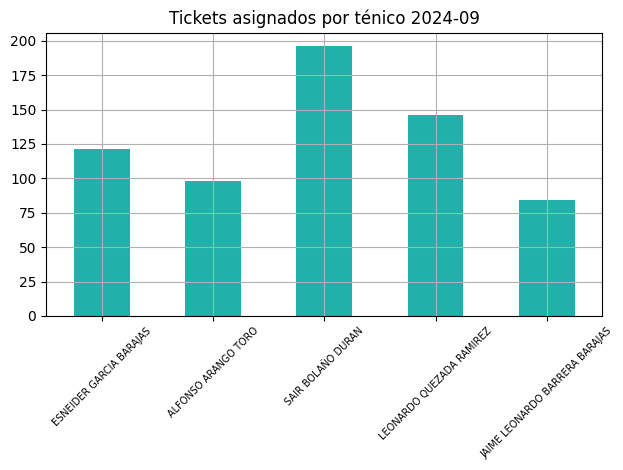

In [15]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-2]
].plot.bar(
    'tecnico','tickets_asignados',
    ax=ax, color='lightseagreen', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-2],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='Tickets asignados por ténico '+meses_estudio[-2],
        xlabel='')
plt.tight_layout()
plt.show()

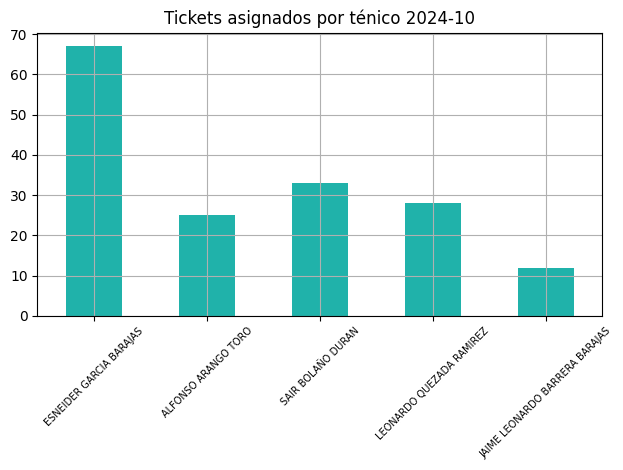

In [16]:
#Mes actual
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-1]
].plot.bar(
    'tecnico','tickets_asignados',
    ax=ax, color='lightseagreen', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-1],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='Tickets asignados por ténico '+meses_estudio[-1],
        xlabel='')
plt.tight_layout()
plt.show()

Tiempo de resolucion por tecnico en el último mes

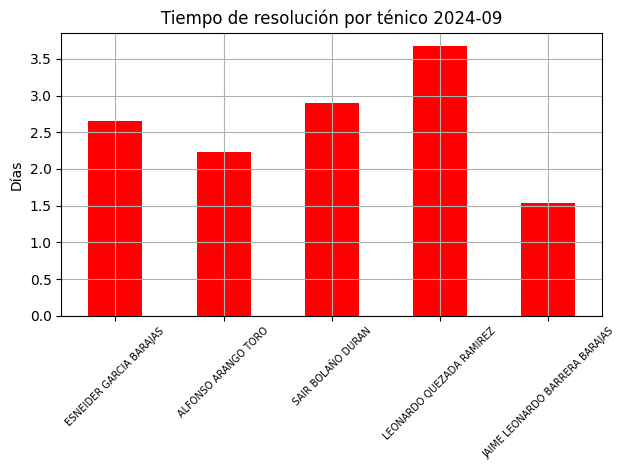

In [17]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-2]
].plot.bar(
    'tecnico','temp_res',
    ax=ax, color='red', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-2],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='Tiempo de resolución por ténico '+meses_estudio[-2],
        xlabel='', ylabel='Días')

plt.tight_layout()
plt.show()

Mes actual

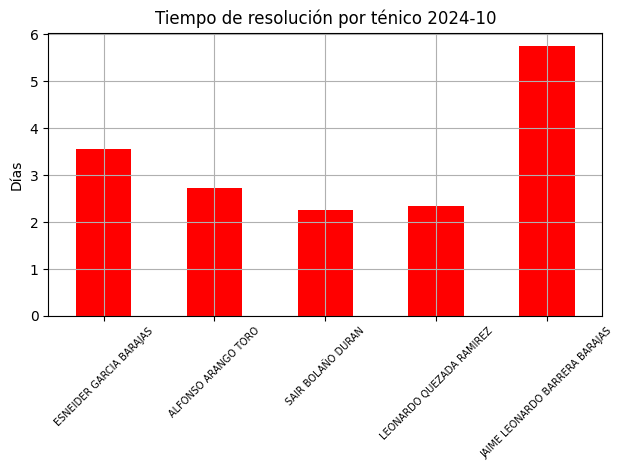

In [18]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-1]
].plot.bar(
    'tecnico','temp_res',
    ax=ax, color='red', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-1],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='Tiempo de resolución por ténico '+meses_estudio[-1],
        xlabel='', ylabel='Días')

plt.tight_layout()
plt.show()

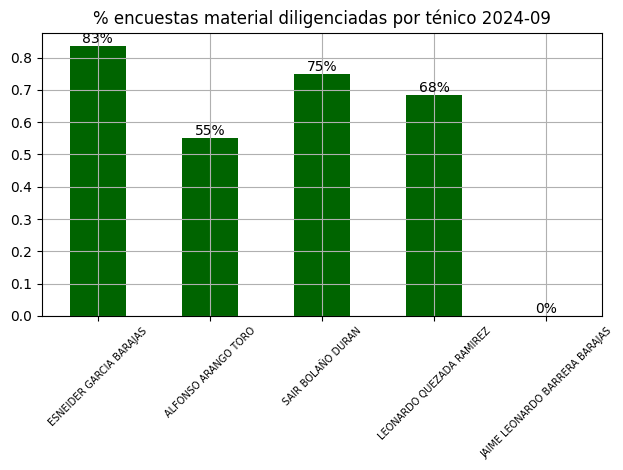

In [19]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-2]
].plot.bar(
    'tecnico','% encuesta material',
    ax=ax, color='darkgreen', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-2],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='% encuestas material diligenciadas por ténico '+meses_estudio[-2],
        xlabel='', ylabel='')

import matplotlib.ticker as mtick
bars = ax.containers[0]
ax.bar_label(bars, labels = [f'{x.get_height():.0%}' for x in bars])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

Mes actual

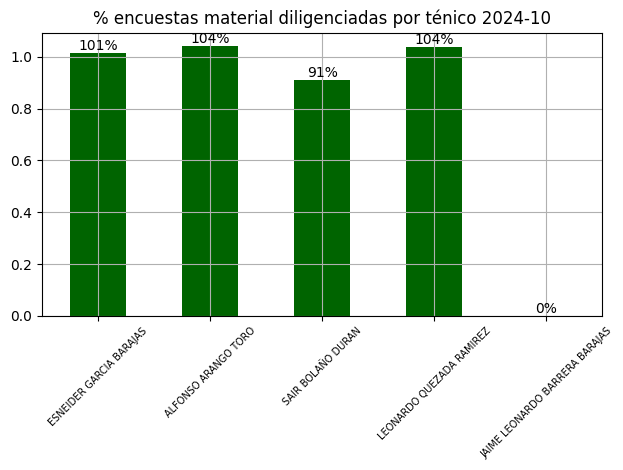

In [20]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-1]
].plot.bar(
    'tecnico','% encuesta material',
    ax=ax, color='darkgreen', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-1],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='% encuestas material diligenciadas por ténico '+meses_estudio[-1],
        xlabel='', ylabel='')

import matplotlib.ticker as mtick
bars = ax.containers[0]
ax.bar_label(bars, labels = [f'{x.get_height():.0%}' for x in bars])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

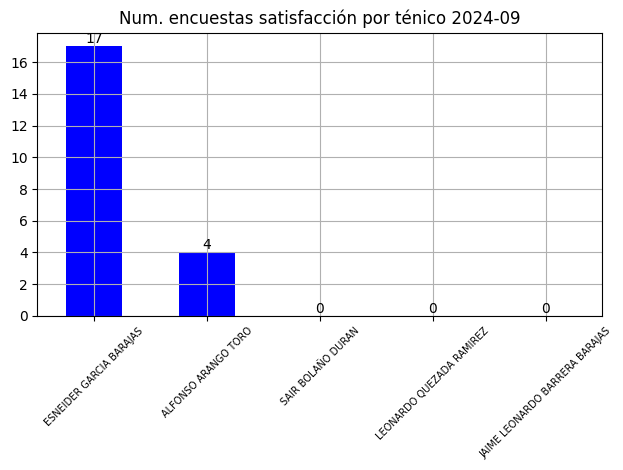

In [21]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-2]
].plot.bar(
    'tecnico','num_enc_satisfaccion',
    ax=ax, color='blue', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-2],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='Num. encuestas satisfacción por ténico '+meses_estudio[-2],
        xlabel='', ylabel='')

import matplotlib.ticker as mtick
bars = ax.containers[0]
ax.bar_label(bars, labels = [f'{x.get_height()}' for x in bars])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

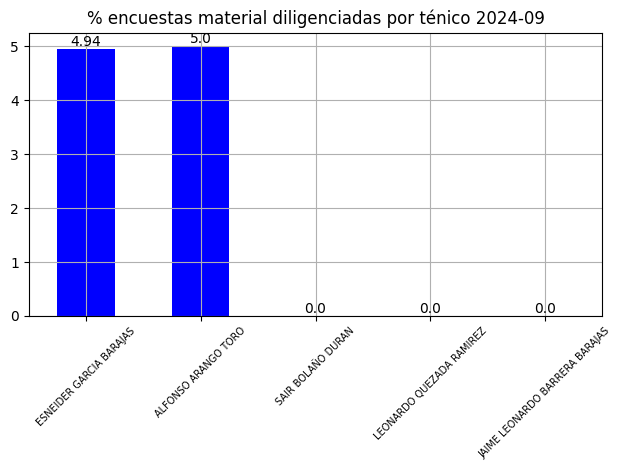

In [22]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

fig, ax=plt.subplots()

summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-2]
].plot.bar(
    'tecnico','promedio_satisfaccion',
    ax=ax, color='blue', 
    grid=True, legend=False)

ax.set_xticklabels([x for x in summary_tecnico_mes.loc[
                    summary_tecnico_mes['mes_crd']==meses_estudio[-2],
                    'tecnico']], rotation=45,size=7)

plt.setp(ax,title='% encuestas material diligenciadas por ténico '+meses_estudio[-2],
        xlabel='', ylabel='')

import matplotlib.ticker as mtick
bars = ax.containers[0]
ax.bar_label(bars, labels = [f'{x.get_height():.3}' for x in bars])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

Mes anterior

In [23]:
#Satisfacción promedio por tecnico
summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-2],
    ['tecnico','num_enc_satisfaccion','promedio_satisfaccion']
]

,tecnico,num_enc_satisfaccion,promedio_satisfaccion
6,ESNEIDER GARCIA BARAJAS,17,4.941176
14,ALFONSO ARANGO TORO,4,5.000000
22,SAIR BOLAÑO DURAN,0,0.000000
30,LEONARDO QUEZADA RAMIREZ,0,0.000000
38,JAIME LEONARDO BARRERA BARAJAS,0,0.000000


Mes actual

In [24]:
#Satisfacción promedio por tecnico
summary_tecnico_mes.loc[
    summary_tecnico_mes[
    'mes_crd']==meses_estudio[-1],
    ['tecnico','num_enc_satisfaccion','promedio_satisfaccion']
]

,tecnico,num_enc_satisfaccion,promedio_satisfaccion
7,ESNEIDER GARCIA BARAJAS,26,4.615385
15,ALFONSO ARANGO TORO,0,0.000000
23,SAIR BOLAÑO DURAN,0,0.000000
31,LEONARDO QUEZADA RAMIREZ,0,0.000000
39,JAIME LEONARDO BARRERA BARAJAS,0,0.000000


In [58]:
meses_estudio=list(summary_tecnico_mes['mes_crd'].unique())[6:]

tecnicos_instaladores=list(summary_tecnico_mes.loc[
    summary_tecnico_mes['mes_crd']==meses_estudio[0],
    'tecnico'
].unique())[:-1]

###ESCALAS DE DESEMPEÑO

resumen_tecnicos_inst={}
for m in meses_estudio:
    
    filepath=os.path.join(
    resultados,
    'Indicadores_tecnicos_instaladores_'+m+'.xlsx')
    
    writer = pd.ExcelWriter(filepath, 
                        engine = 'xlsxwriter') 
    
    resumen_tecnicos_inst[m]={}
    
    for t in tecnicos_instaladores:
        resumen_tecnicos_inst[m][t]=pd.DataFrame()
        resumen_tecnicos_inst[m][t].loc[
            :,t]=summary_tecnico_mes.loc[
            (summary_tecnico_mes['mes_crd']==m) & 
            (summary_tecnico_mes['tecnico']==t)].iloc[0].loc[[
                'mes_crd','tickets_asignados',
                'Encuestas respondidas','% encuesta material',
                'num_enc_satisfaccion','% encuesta satisfaccion',
                'Satisfaccion del usuario','promedio_satisfaccion','temp_res']]


        ###OJO META DE LOS TÉCNICOS MENSUAL
        resumen_tecnicos_inst[m][t].loc[
                :,'Meta']=[m,None,None,
                           
                           #PORCENTAJE ENCUESTAS MATERIAL RESPONDIDAS
                           .8,None,None,
                           #PROMOTORES
                           .8,None,
                           #TIEMPO RESOLUCIÓN
                           pd.to_timedelta(3.5, unit='d')]


        ##PORCENTAJE DE CUMPLIMIENTO
        resumen_tecnicos_inst[m][t].loc[:,
        '% Cumplimiento']=resumen_tecnicos_inst[m][t].loc[
        (resumen_tecnicos_inst[m][t].index=='% encuesta material') |
        (resumen_tecnicos_inst[m][t].index=='Satisfaccion del usuario')][t]/resumen_tecnicos_inst[m][t].loc[
        (resumen_tecnicos_inst[m][t].index=='% encuesta material') |
        (resumen_tecnicos_inst[m][t].index=='Satisfaccion del usuario')]['Meta']

        resumen_tecnicos_inst[m][t].loc[
                resumen_tecnicos_inst[m][t].index=='temp_res',
        '% Cumplimiento']=(1-(resumen_tecnicos_inst[m][t].loc[
                resumen_tecnicos_inst[m][t].index=='temp_res'][t]-
                              pd.to_timedelta(resumen_tecnicos_inst[m][t].loc[
                resumen_tecnicos_inst[m][t].index=='temp_res']['Meta']).dt.total_seconds(
                                  
                )/(60*60*24))/pd.to_timedelta(resumen_tecnicos_inst[m][t].loc[
                resumen_tecnicos_inst[m][t].index=='temp_res']['Meta']).dt.total_seconds(
                                  
                )/(60*60*24))
        
        ###CALIFICACION DEL DESEMPEÑO
        resumen_tecnicos_inst[m][t].loc[:,
        'Desempeño']=np.select([resumen_tecnicos_inst[m][t]['% Cumplimiento']>=1,
                                (resumen_tecnicos_inst[m][t]['% Cumplimiento']>=.8) &
                                (resumen_tecnicos_inst[m][t]['% Cumplimiento']<1), 
                                (resumen_tecnicos_inst[m][t]['% Cumplimiento']>=.5) &
                                (resumen_tecnicos_inst[m][t]['% Cumplimiento']<.8), 
                                (resumen_tecnicos_inst[m][t]['% Cumplimiento']>=0) &
                                (resumen_tecnicos_inst[m][t]['% Cumplimiento']<.5)],
                               ['Excelente','Destacado','Oportunidad','Crítico'], default='')
        
        resumen_tecnicos_inst[m][t].loc[
        'Promedio','% Cumplimiento']=resumen_tecnicos_inst[m][t][
        '% Cumplimiento'].mean()

        resumen_tecnicos_inst[m][t].loc[
        'Promedio','Desempeño']=np.select(
            [resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] >= 1,
             (resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] >= 0.8) &
             (resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] < 1), 
             (resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] >= 0.5) &
             (resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] < 0.8), 
             (resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] >= 0) &
             (resumen_tecnicos_inst[m][t].loc['Promedio', '% Cumplimiento'] < 0.5)],
            ['Excelente', 'Destacado', 'Oportunidad', 'Crítico'], default=''
        )
        
        #resumen_tecnicos_inst[t].fillna(0, inplace=True)

        resumen_tecnicos_inst[m][t].index=['Mes','Tickets asignados','Encuestas material', '% encuesta material respondidas',
                                                       'Num. encuestas satisfaccion','% Enc. sat. respondidas', 'Satisfaccion del usuario',
                                                       'Promedio satisfacción','Tiempo resolución','Promedio']
        
        resumen_tecnicos_inst[m][t].to_excel(
                writer, sheet_name=t)

    writer.close()

In [85]:
#Defino meses de estudio
meses_estudio = list(summary_tecnico_mes['mes_crd'].unique())[6:]

#Defino tecnicos instaladores
tecnicos_instaladores = list(summary_tecnico_mes.loc[
    summary_tecnico_mes['mes_crd'] == meses_estudio[0],
    'tecnico'
].unique())[:-1]

# Definir una función para evaluar el desempeño basado en % Cumplimiento
def evaluar_desempeno(cumplimiento):
    return np.select(
        [cumplimiento >= 1,
         (cumplimiento >= 0.8) & (cumplimiento < 1),
         (cumplimiento >= 0.5) & (cumplimiento < 0.8),
         (cumplimiento >= 0) & (cumplimiento < 0.5)],
        ['Excelente', 'Destacado', 'Oportunidad', 'Crítico'],
        default=''
    )

#Almaceno todo en un dict
resumen_tecnicos_inst = {}
for m in meses_estudio:
    
    filepath = os.path.join(
        resultados,
        'Indicadores_tecnicos_instaladores_' + m + '.xlsx'
    )
    
    writer = pd.ExcelWriter(filepath, engine='xlsxwriter') 
    
    resumen_tecnicos_inst[m] = {}
    
    for t in tecnicos_instaladores:
        resumen_tecnicos_inst[m][t] = pd.DataFrame()
        
        # Crear la columna con los datos del técnico en la hoja correspondiente
        resumen_tecnicos_inst[m][t][t] = summary_tecnico_mes.loc[
            (summary_tecnico_mes['mes_crd'] == m) & 
            (summary_tecnico_mes['tecnico'] == t)].iloc[0].loc[[
                'mes_crd', 'tickets_asignados',
                'Encuestas respondidas', '% encuesta material',
                'num_enc_satisfaccion', '% encuesta satisfaccion',
                'Satisfaccion del usuario', 'promedio_satisfaccion', 'temp_res'
            ]]

        # OJO META DE LOS TÉCNICOS MENSUAL
        resumen_tecnicos_inst[m][t]['Meta'] = [m, None, None,
                          # PORCENTAJE ENCUESTAS MATERIAL RESPONDIDAS
                          0.8, None, None,
                          # PROMOTORES
                          0.8, None,
                          # TIEMPO RESOLUCIÓN
                          3.5]

        # PORCENTAJE DE CUMPLIMIENTO
        resumen_tecnicos_inst[m][t]['% Cumplimiento'] = resumen_tecnicos_inst[m][t].loc[
            (resumen_tecnicos_inst[m][t].index == '% encuesta material') |
            (resumen_tecnicos_inst[m][t].index == 'Satisfaccion del usuario')][t] / resumen_tecnicos_inst[m][t].loc[
            (resumen_tecnicos_inst[m][t].index == '% encuesta material') |
            (resumen_tecnicos_inst[m][t].index == 'Satisfaccion del usuario')]['Meta']

        # Convertir timedelta a días para calcular el % Cumplimiento de temp_res
        real_resolucion = resumen_tecnicos_inst[m][t].loc[
        resumen_tecnicos_inst[m][t].index == 'temp_res', t]

        meta_resolucion = resumen_tecnicos_inst[m][t].loc[
        resumen_tecnicos_inst[m][t].index == 'temp_res', 'Meta']

        # Calcular el % Cumplimiento basado en los días
        resumen_tecnicos_inst[m][t].loc[
        resumen_tecnicos_inst[m][t].index == 'temp_res', '% Cumplimiento'] = 1 - (real_resolucion - 
                                                                                  meta_resolucion) / meta_resolucion

        # Definir los pesos (ejemplo: puedes ajustar según el criterio)
        pesos = {
                    '% encuesta material': 0.15,
                    'Satisfaccion del usuario': 0.25,
                    'temp_res': 0.6
                    }

        # Asegúrate de que cada técnico tenga una columna de peso
        resumen_tecnicos_inst[m][t]['Peso'] = resumen_tecnicos_inst[m][t].index.map(pesos).fillna(0)

        # Calcular el promedio ponderado del % de cumplimiento
        resumen_tecnicos_inst[m][t].loc['Promedio ponderado', '% Cumplimiento'] = (
            resumen_tecnicos_inst[m][t]['% Cumplimiento'] * resumen_tecnicos_inst[m][t]['Peso']
            ).sum() / resumen_tecnicos_inst[m][t]['Peso'].sum()

        # Calificación del desempeño para cada técnico
        resumen_tecnicos_inst[m][t]['Desempeño'] = evaluar_desempeno(
            resumen_tecnicos_inst[m][t]['% Cumplimiento']
        )
        
        # Calificación del desempeño para el promedio ponderado
        resumen_tecnicos_inst[m][t].loc['Promedio ponderado', 'Desempeño'] = evaluar_desempeno(
            resumen_tecnicos_inst[m][t].loc['Promedio ponderado', '% Cumplimiento']
        )

        # Ajustar los índices
        resumen_tecnicos_inst[m][t].index = ['Mes', 'Tickets asignados', 'Encuestas material', 
                                             '% encuesta material respondidas', 'Num. encuestas satisfaccion', 
                                             '% Enc. sat. respondidas', 'Satisfaccion del usuario',
                                             'Promedio satisfacción', 'Tiempo resolución', 'Promedio ponderado']

        # Guardar en la hoja de Excel
        resumen_tecnicos_inst[m][t].iloc[:,np.r_[:3,4]].to_excel(writer, sheet_name=t)

    # Cerrar el archivo Excel
    writer.close()


In [87]:
resumen_tecnicos_inst['2024-09']['SAIR BOLAÑO DURAN'].iloc[:,np.r_[:3,4]]

,SAIR BOLAÑO DURAN,Meta,% Cumplimiento,Desempeño
Mes,2024-09,2024-09,NaN,
Tickets asignados,196,None,NaN,
Encuestas material,147,None,NaN,
% encuesta material respondidas,0.75,0.8,0.9375,Destacado
Num. encuestas satisfaccion,0,None,NaN,
% Enc. sat. respondidas,0.0,None,NaN,
Satisfaccion del usuario,NaN,0.8,NaN,
Promedio satisfacción,0.0,None,NaN,
Tiempo resolución,2.903858,3.5,1.170326,Excelente
Promedio ponderado,NaN,NaN,0.842821,Destacado
